In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Using GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Setting hyper parameters
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

In [12]:
# Getting data ready
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class NN_2_hidden_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN_2_hidden_layers, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)


class NN_3_hidden_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN_3_hidden_layers, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)


class NN_4_hidden_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN_4_hidden_layers, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.l5 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)


class NN_5_hidden_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN_5_hidden_layers, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.l5 = nn.Linear(hidden_size, hidden_size)
        self.l6 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        out = self.relu(out)
        out = self.l6(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
          if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [14]:
def train_loop(model, learning_rate):
  model.initialize_weights()

  # Training Loop
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
      model.train()

      train_loss = 0.0
      train_correct = 0
      train_total = 0

      # enumerate used to get batch index
      for batch_idx, (data, targets) in enumerate(train_loader):
          data = data.to(device).reshape(data.shape[0], -1)
          targets = targets.to(device)

          # Forward pass
          optimizer.zero_grad()
          outputs = model(data)
          loss = loss_function(outputs, targets)

          # Backward pass
          loss.backward()
          optimizer.step()

          # Track metrics
          train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()

      # VALIDATION
      model.eval()
      val_loss = 0
      val_correct = 0
      val_total = 0

      # We don't need gradients because we're not training
      with torch.no_grad():
          for data, targets in val_loader:
              data = data.reshape(data.shape[0], -1).to(device)
              targets = targets.to(device)

              outputs = model(data)
              loss = loss_function(outputs, targets)

              val_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              val_total += targets.size(0)
              val_correct += (predicted == targets).sum().item()

      # Save metrics
      train_losses.append(train_loss / len(train_loader))
      val_losses.append(val_loss / len(val_loader))
      train_accuracies.append(100 * train_correct / train_total)
      val_accuracies.append(100 * val_correct / val_total)

      print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_losses[-1]:.3f}, Val Loss={val_losses[-1]:.3f}')

  return train_losses, val_losses, train_accuracies, val_accuracies

=== Running baseline model multiple times ===
Run 1/5
Epoch 1/20: Train Loss=0.874, Val Loss=0.432
Epoch 2/20: Train Loss=0.373, Val Loss=0.331
Epoch 3/20: Train Loss=0.308, Val Loss=0.292
Epoch 4/20: Train Loss=0.274, Val Loss=0.265
Epoch 5/20: Train Loss=0.249, Val Loss=0.244
Epoch 6/20: Train Loss=0.229, Val Loss=0.229
Epoch 7/20: Train Loss=0.214, Val Loss=0.215
Epoch 8/20: Train Loss=0.200, Val Loss=0.204
Epoch 9/20: Train Loss=0.188, Val Loss=0.195
Epoch 10/20: Train Loss=0.178, Val Loss=0.185
Epoch 11/20: Train Loss=0.169, Val Loss=0.178
Epoch 12/20: Train Loss=0.161, Val Loss=0.171
Epoch 13/20: Train Loss=0.153, Val Loss=0.165
Epoch 14/20: Train Loss=0.146, Val Loss=0.159
Epoch 15/20: Train Loss=0.140, Val Loss=0.155
Epoch 16/20: Train Loss=0.134, Val Loss=0.151
Epoch 17/20: Train Loss=0.129, Val Loss=0.146
Epoch 18/20: Train Loss=0.124, Val Loss=0.142
Epoch 19/20: Train Loss=0.119, Val Loss=0.141
Epoch 20/20: Train Loss=0.115, Val Loss=0.138
Run 2/5
Epoch 1/20: Train Loss=0.88

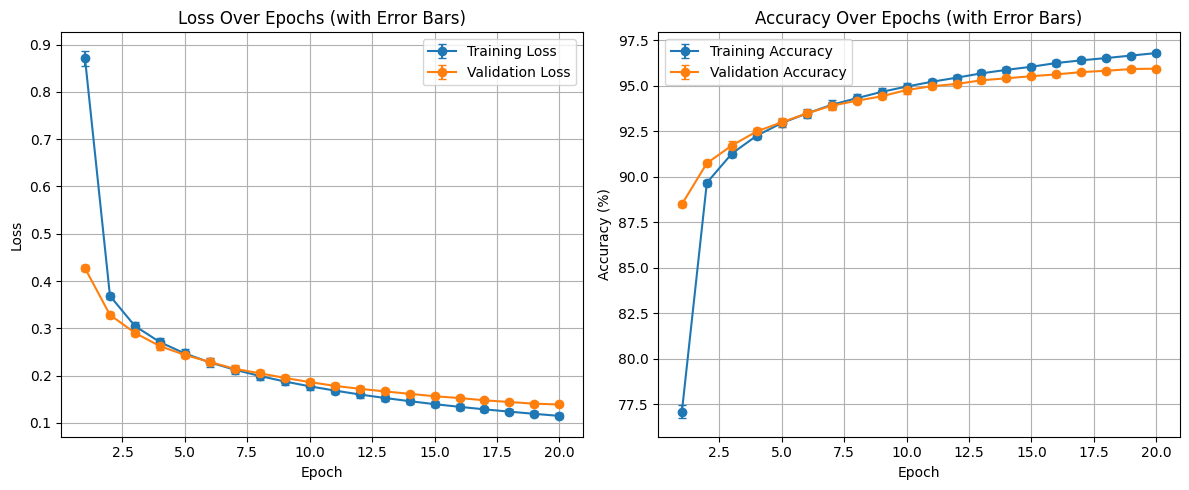


=== Convergence Analysis ===
Final Performance (Mean ± Std over 5 runs):
  Training Loss:       0.1148 ± 0.0052
  Validation Loss:     0.1389 ± 0.0026
  Training Accuracy:   96.79% ± 0.13%
  Validation Accuracy: 95.94% ± 0.08%

Model converged around epoch 8
Train-Val accuracy gap: 0.86% (minimal overfitting)


In [ ]:
# Plotting Performance Visualization for baseline Hyperparameters

# === Run multiple times for error bars ===
num_runs = 5
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []

print("=== Running baseline model multiple times ===")
for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    model = NN_2_hidden_layers(input_size, hidden_size, num_classes).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, learning_rate)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accuracies)
    all_val_accs.append(val_accuracies)

# Calculate mean and std
all_train_losses = np.array(all_train_losses)
all_val_losses = np.array(all_val_losses)
all_train_accs = np.array(all_train_accs)
all_val_accs = np.array(all_val_accs)

mean_train_loss = np.mean(all_train_losses, axis=0)
std_train_loss = np.std(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
mean_train_acc = np.mean(all_train_accs, axis=0)
std_train_acc = np.std(all_train_accs, axis=0)
mean_val_acc = np.mean(all_val_accs, axis=0)
std_val_acc = np.std(all_val_accs, axis=0)

epochs_range = range(1, num_epochs + 1)

# === Plot with error bars ===
plt.figure(figsize=(12, 5))

# Training and Validation Loss with error bars
plt.subplot(1, 2, 1)
plt.errorbar(epochs_range, mean_train_loss, yerr=std_train_loss, label='Training Loss', marker='o', capsize=3)
plt.errorbar(epochs_range, mean_val_loss, yerr=std_val_loss, label='Validation Loss', marker='o', capsize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (with Error Bars)')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy with error bars
plt.subplot(1, 2, 2)
plt.errorbar(epochs_range, mean_train_acc, yerr=std_train_acc, label='Training Accuracy', marker='o', capsize=3)
plt.errorbar(epochs_range, mean_val_acc, yerr=std_val_acc, label='Validation Accuracy', marker='o', capsize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs (with Error Bars)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Enhanced Convergence Analysis ===
print("\n=== Convergence Analysis ===")
print(f"Final Performance (Mean ± Std over {num_runs} runs):")
print(f"  Training Loss:       {mean_train_loss[-1]:.4f} ± {std_train_loss[-1]:.4f}")
print(f"  Validation Loss:     {mean_val_loss[-1]:.4f} ± {std_val_loss[-1]:.4f}")
print(f"  Training Accuracy:   {mean_train_acc[-1]:.2f}% ± {std_train_acc[-1]:.2f}%")
print(f"  Validation Accuracy: {mean_val_acc[-1]:.2f}% ± {std_val_acc[-1]:.2f}%")

# Find when model converged
for i in range(1, len(mean_val_loss)):
    if abs(mean_val_loss[i-1] - mean_val_loss[i]) < 0.01:
        print(f"\nModel converged around epoch {i+1}")
        break

# Overfitting check
gap = mean_train_acc[-1] - mean_val_acc[-1]
print(f"Train-Val accuracy gap: {gap:.2f}%", end=" ")
print("(minimal overfitting)" if gap < 5 else "(some overfitting detected)")

In [ ]:
def plot_comparison(comparison_results, comparison_name):

    plt.figure(figsize=(14, 6))

    # Training Loss Comparison
    plt.subplot(1, 2, 1)
    for label, results in comparison_results.items():
        plt.plot(results['train_losses'], label=f'{comparison_name}={label}', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True)

    # Validation Accuracy Comparison
    plt.subplot(1, 2, 2)
    for label, results in comparison_results.items():
        plt.plot(results['val_accuracies'], label=f'{comparison_name}={label}', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n=== {comparison_name} Comparison Summary ===")
    for label, results in comparison_results.items():
        print(f"{comparison_name}={label}: Final Val Acc = {results['val_accuracies'][-1]:.2f}%")


=== Training with Learning Rate: 0.001 ===
Epoch 1/20: Train Loss=2.068, Val Loss=1.744
Epoch 2/20: Train Loss=1.461, Val Loss=1.205
Epoch 3/20: Train Loss=1.034, Val Loss=0.890
Epoch 4/20: Train Loss=0.801, Val Loss=0.722
Epoch 5/20: Train Loss=0.671, Val Loss=0.622
Epoch 6/20: Train Loss=0.589, Val Loss=0.557
Epoch 7/20: Train Loss=0.533, Val Loss=0.510
Epoch 8/20: Train Loss=0.493, Val Loss=0.476
Epoch 9/20: Train Loss=0.461, Val Loss=0.449
Epoch 10/20: Train Loss=0.437, Val Loss=0.428
Epoch 11/20: Train Loss=0.417, Val Loss=0.411
Epoch 12/20: Train Loss=0.401, Val Loss=0.396
Epoch 13/20: Train Loss=0.387, Val Loss=0.384
Epoch 14/20: Train Loss=0.375, Val Loss=0.374
Epoch 15/20: Train Loss=0.365, Val Loss=0.364
Epoch 16/20: Train Loss=0.356, Val Loss=0.356
Epoch 17/20: Train Loss=0.348, Val Loss=0.349
Epoch 18/20: Train Loss=0.341, Val Loss=0.342
Epoch 19/20: Train Loss=0.334, Val Loss=0.336
Epoch 20/20: Train Loss=0.328, Val Loss=0.331

=== Training with Learning Rate: 0.01 ===
Ep

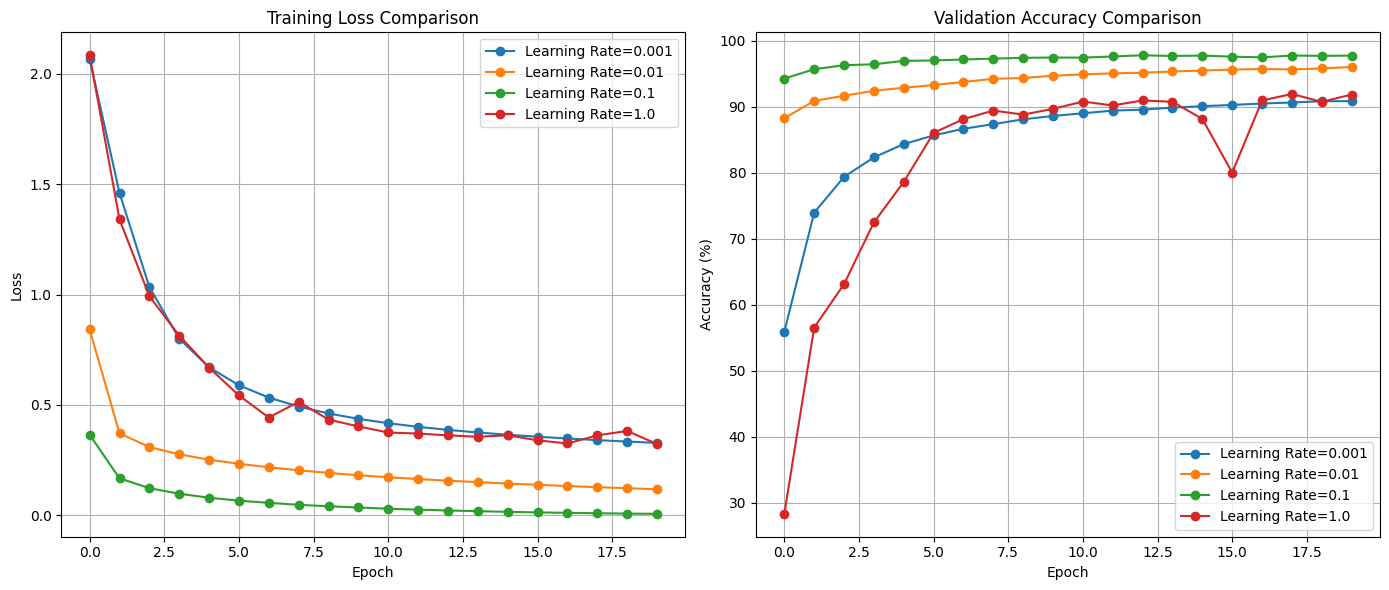


=== Learning Rate Comparison Summary ===
Learning Rate=0.001: Final Val Acc = 90.84%
Learning Rate=0.01: Final Val Acc = 96.02%
Learning Rate=0.1: Final Val Acc = 97.73%
Learning Rate=1.0: Final Val Acc = 91.84%


In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
lr_results = {}

for lr in learning_rates:

  print(f"\n=== Training with Learning Rate: {lr} ===")

  model = NN_2_hidden_layers(input_size, hidden_size, num_classes).to(device)
  train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, lr)

  lr_results[lr] = {
      'train_losses': train_losses,
      'val_losses': val_losses,
      'train_accuracies': train_accuracies,
      'val_accuracies': val_accuracies
  }


plot_comparison(lr_results, "Learning Rate")



=== Training with Batch Size: 16 ===
Epoch 1/20: Train Loss=0.466, Val Loss=0.273
Epoch 2/20: Train Loss=0.232, Val Loss=0.205
Epoch 3/20: Train Loss=0.183, Val Loss=0.174
Epoch 4/20: Train Loss=0.153, Val Loss=0.154
Epoch 5/20: Train Loss=0.132, Val Loss=0.146
Epoch 6/20: Train Loss=0.115, Val Loss=0.132
Epoch 7/20: Train Loss=0.102, Val Loss=0.121
Epoch 8/20: Train Loss=0.091, Val Loss=0.115
Epoch 9/20: Train Loss=0.081, Val Loss=0.111
Epoch 10/20: Train Loss=0.073, Val Loss=0.106
Epoch 11/20: Train Loss=0.066, Val Loss=0.100
Epoch 12/20: Train Loss=0.061, Val Loss=0.099
Epoch 13/20: Train Loss=0.055, Val Loss=0.099
Epoch 14/20: Train Loss=0.051, Val Loss=0.096
Epoch 15/20: Train Loss=0.047, Val Loss=0.092
Epoch 16/20: Train Loss=0.043, Val Loss=0.094
Epoch 17/20: Train Loss=0.040, Val Loss=0.094
Epoch 18/20: Train Loss=0.037, Val Loss=0.092
Epoch 19/20: Train Loss=0.034, Val Loss=0.096
Epoch 20/20: Train Loss=0.031, Val Loss=0.093

=== Training with Batch Size: 32 ===
Epoch 1/20: T

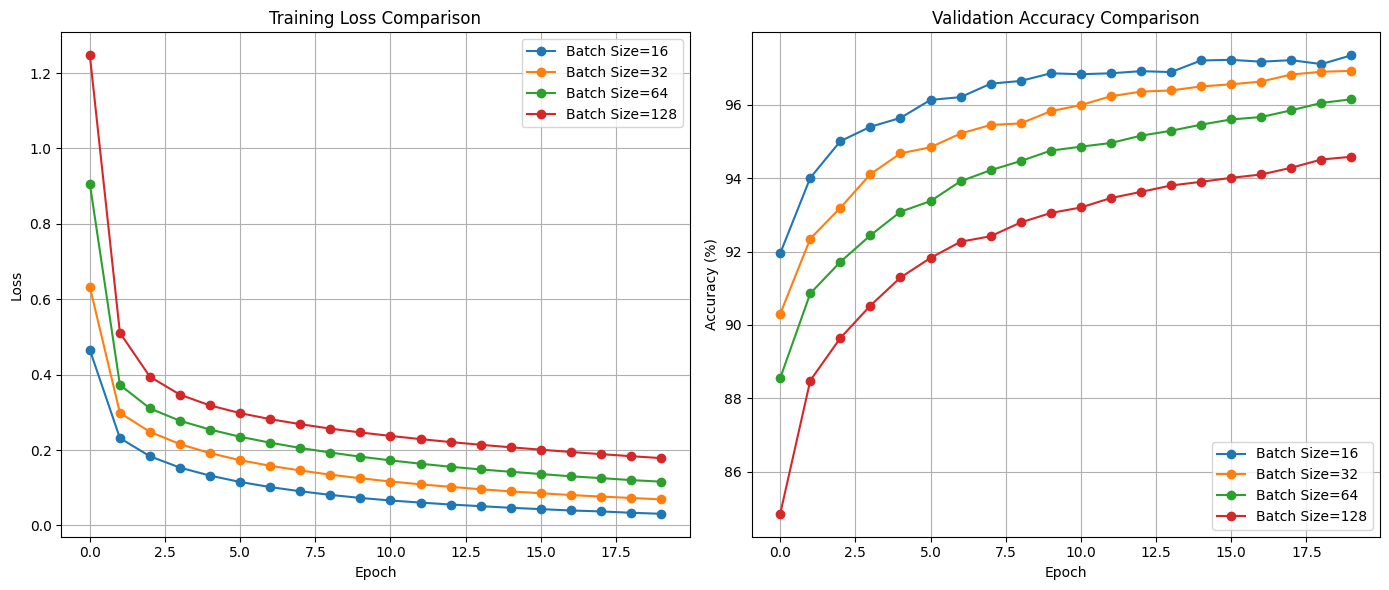


=== Batch Size Comparison Summary ===
Batch Size=16: Final Val Acc = 97.35%
Batch Size=32: Final Val Acc = 96.92%
Batch Size=64: Final Val Acc = 96.15%
Batch Size=128: Final Val Acc = 94.58%


In [ ]:
batch_sizes = [16, 32, 64, 128]
batch_results = {}

for bs in batch_sizes:
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)

  print(f"\n=== Training with Batch Size: {bs} ===")

  model = NN_2_hidden_layers(input_size, hidden_size, num_classes).to(device)
  train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, learning_rate)

  batch_results[bs] = {
      'train_losses': train_losses,
      'val_losses': val_losses,
      'train_accuracies': train_accuracies,
      'val_accuracies': val_accuracies
  }


plot_comparison(batch_results, "Batch Size")



=== Training with Hidden Size: 64 ===
Epoch 1/20: Train Loss=1.201, Val Loss=0.618
Epoch 2/20: Train Loss=0.504, Val Loss=0.432
Epoch 3/20: Train Loss=0.398, Val Loss=0.370
Epoch 4/20: Train Loss=0.353, Val Loss=0.339
Epoch 5/20: Train Loss=0.327, Val Loss=0.317
Epoch 6/20: Train Loss=0.307, Val Loss=0.303
Epoch 7/20: Train Loss=0.292, Val Loss=0.288
Epoch 8/20: Train Loss=0.280, Val Loss=0.278
Epoch 9/20: Train Loss=0.269, Val Loss=0.267
Epoch 10/20: Train Loss=0.259, Val Loss=0.257
Epoch 11/20: Train Loss=0.249, Val Loss=0.249
Epoch 12/20: Train Loss=0.241, Val Loss=0.242
Epoch 13/20: Train Loss=0.233, Val Loss=0.235
Epoch 14/20: Train Loss=0.226, Val Loss=0.227
Epoch 15/20: Train Loss=0.219, Val Loss=0.221
Epoch 16/20: Train Loss=0.213, Val Loss=0.216
Epoch 17/20: Train Loss=0.206, Val Loss=0.209
Epoch 18/20: Train Loss=0.201, Val Loss=0.205
Epoch 19/20: Train Loss=0.195, Val Loss=0.201
Epoch 20/20: Train Loss=0.190, Val Loss=0.198

=== Training with Hidden Size: 128 ===
Epoch 1/20

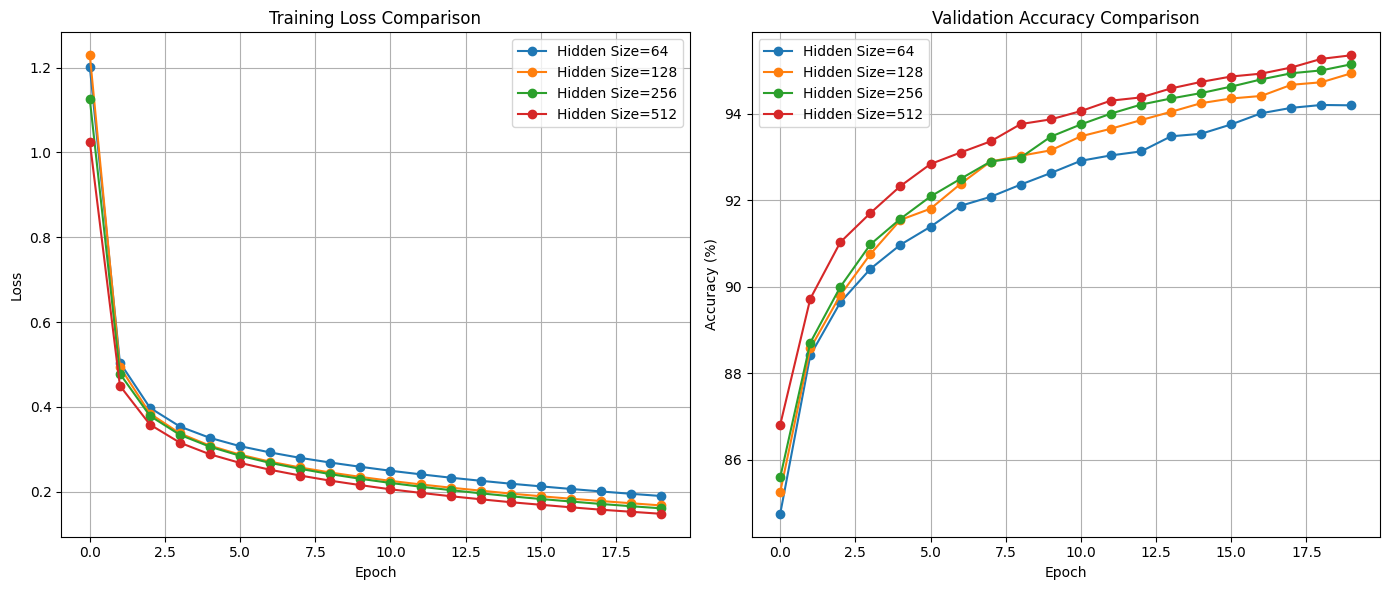


=== Hidden Size Comparison Summary ===
Hidden Size=64: Final Val Acc = 94.20%
Hidden Size=128: Final Val Acc = 94.94%
Hidden Size=256: Final Val Acc = 95.15%
Hidden Size=512: Final Val Acc = 95.36%


In [ ]:
hidden_sizes = [64, 128, 256, 512]
hidden_size_results = {}

for hs in hidden_sizes:
    print(f"\n=== Training with Hidden Size: {hs} ===")

    model = NN_2_hidden_layers(input_size, hs, num_classes).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, learning_rate)

    hidden_size_results[hs] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

plot_comparison(hidden_size_results, "Hidden Size")


=== Training with 2 Hidden Layers ===
Epoch 1/20: Train Loss=1.383, Val Loss=0.712
Epoch 2/20: Train Loss=0.556, Val Loss=0.454
Epoch 3/20: Train Loss=0.411, Val Loss=0.374
Epoch 4/20: Train Loss=0.354, Val Loss=0.336
Epoch 5/20: Train Loss=0.321, Val Loss=0.310
Epoch 6/20: Train Loss=0.298, Val Loss=0.291
Epoch 7/20: Train Loss=0.281, Val Loss=0.276
Epoch 8/20: Train Loss=0.266, Val Loss=0.264
Epoch 9/20: Train Loss=0.253, Val Loss=0.253
Epoch 10/20: Train Loss=0.242, Val Loss=0.244
Epoch 11/20: Train Loss=0.232, Val Loss=0.235
Epoch 12/20: Train Loss=0.223, Val Loss=0.227
Epoch 13/20: Train Loss=0.215, Val Loss=0.221
Epoch 14/20: Train Loss=0.208, Val Loss=0.213
Epoch 15/20: Train Loss=0.200, Val Loss=0.206
Epoch 16/20: Train Loss=0.194, Val Loss=0.202
Epoch 17/20: Train Loss=0.188, Val Loss=0.196
Epoch 18/20: Train Loss=0.182, Val Loss=0.192
Epoch 19/20: Train Loss=0.177, Val Loss=0.188
Epoch 20/20: Train Loss=0.173, Val Loss=0.185

=== Training with 3 Hidden Layers ===
Epoch 1/20:

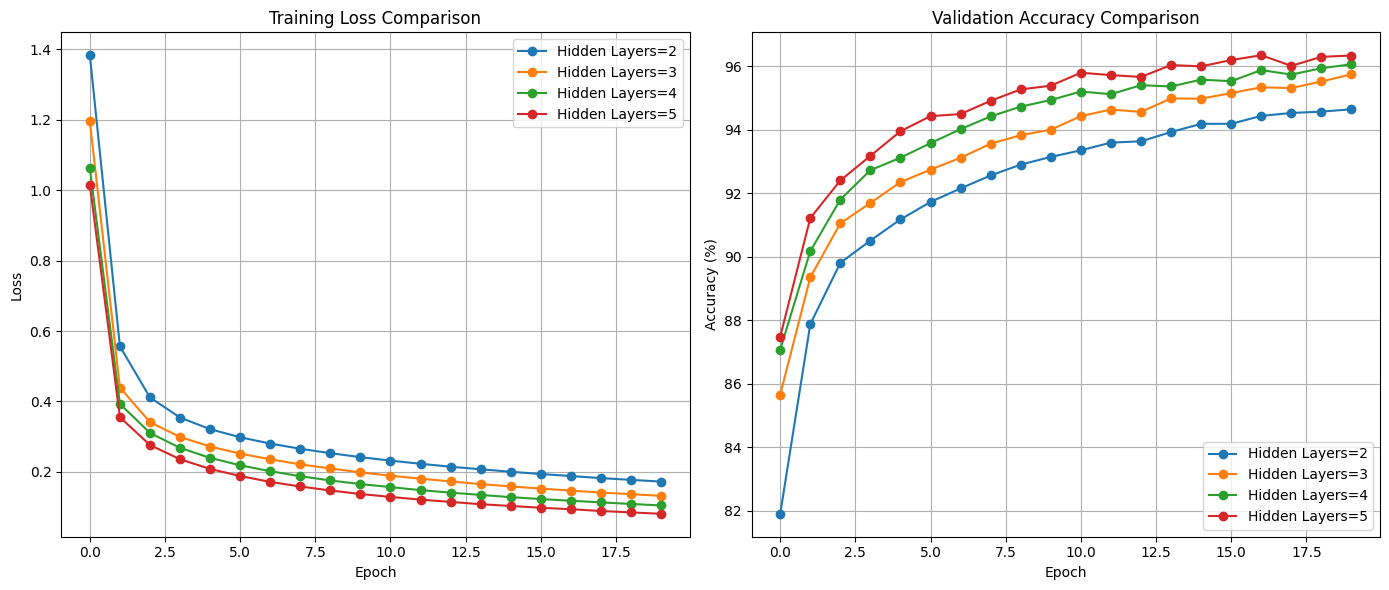


=== Hidden Layers Comparison Summary ===
Hidden Layers=2: Final Val Acc = 94.64%
Hidden Layers=3: Final Val Acc = 95.74%
Hidden Layers=4: Final Val Acc = 96.06%
Hidden Layers=5: Final Val Acc = 96.33%


In [ ]:
models_by_layers = {
    2: NN_2_hidden_layers,
    3: NN_3_hidden_layers,
    4: NN_4_hidden_layers,
    5: NN_5_hidden_layers
}

layer_results = {}

for num_layers, ModelClass in models_by_layers.items():

    print(f"\n=== Training with {num_layers} Hidden Layers ===")

    model = ModelClass(input_size, hidden_size, num_classes).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, learning_rate)

    layer_results[num_layers] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

plot_comparison(layer_results, "Hidden Layers")

In [8]:
def model_test(model):

    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0

    loss_function = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.reshape(data.shape[0], -1).to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = loss_function(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total

    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return avg_test_loss, test_accuracy

In [15]:
# putting best hyper parameters
hidden_size = 512
batch_size = 16
learning_rate = 0.1

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
model = NN_5_hidden_layers(input_size, hidden_size, num_classes).to(device)

print("Training best model...")
train_loop(model, learning_rate)

print("\nTesting on test set...")
model_test(model)

Training best model...
Epoch 1/20: Train Loss=0.292, Val Loss=0.130
Epoch 2/20: Train Loss=0.103, Val Loss=0.104
Epoch 3/20: Train Loss=0.064, Val Loss=0.106
Epoch 4/20: Train Loss=0.039, Val Loss=0.086
Epoch 5/20: Train Loss=0.026, Val Loss=0.089
Epoch 6/20: Train Loss=0.019, Val Loss=0.100
Epoch 7/20: Train Loss=0.012, Val Loss=0.097
Epoch 8/20: Train Loss=0.008, Val Loss=0.123
Epoch 9/20: Train Loss=0.006, Val Loss=0.099
Epoch 10/20: Train Loss=0.001, Val Loss=0.103
Epoch 11/20: Train Loss=0.000, Val Loss=0.100
Epoch 12/20: Train Loss=0.000, Val Loss=0.103
Epoch 13/20: Train Loss=0.000, Val Loss=0.105
Epoch 14/20: Train Loss=0.000, Val Loss=0.107
Epoch 15/20: Train Loss=0.000, Val Loss=0.109
Epoch 16/20: Train Loss=0.000, Val Loss=0.110
Epoch 17/20: Train Loss=0.000, Val Loss=0.111
Epoch 18/20: Train Loss=0.000, Val Loss=0.112
Epoch 19/20: Train Loss=0.000, Val Loss=0.113
Epoch 20/20: Train Loss=0.000, Val Loss=0.114

Testing on test set...
Test Loss: 0.0869
Test Accuracy: 98.31%


(0.08693285841494146, 98.31)